In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from asa.plot_methods import plot_trend

import jax.numpy as jnp
from raddest.api.flowvi import FlowVI
from raddest.api.fitter import LogLinearML, LogLinearKS
from raddest.transfer import NegLogPlus

In [4]:
plt.style.use('science')
plt.rcParams.update({'font.size': 15})

In [5]:
N = 10000
k = 2.0
b = 1.0
sigma = 0.2

logx = np.random.normal(0, 0.3, size=N)
logy = k * logx + b + np.random.normal(0, sigma, size=N)

x = 10**logx
y = 10**logy

x_err = np.median(x) / np.random.uniform(4.5, 5.5, size=N)
y_err = np.median(y) / np.random.uniform(4.5, 5.5, size=N)

x_err_2 = x / np.random.uniform(1.5, 2.5, size=N)
y_err_2 = y / np.random.uniform(1.5, 2.5, size=N)

x_obs = x + np.random.normal(0, x_err, size=N)
y_obs = y + np.random.normal(0, y_err, size=N)

x_obs_2 = x + np.random.normal(0, x_err_2, size=N)
y_obs_2 = y + np.random.normal(0, y_err_2, size=N)


x_err = jnp.array(x_err)
y_err = jnp.array(y_err)

x_err_2 = jnp.array(x_err_2)
y_err_2 = jnp.array(y_err_2)

x_obs = jnp.array(x_obs)
y_obs = jnp.array(y_obs)

x_obs_2 = jnp.array(x_obs_2)
y_obs_2 = jnp.array(y_obs_2)

### Intrinsic Scatter

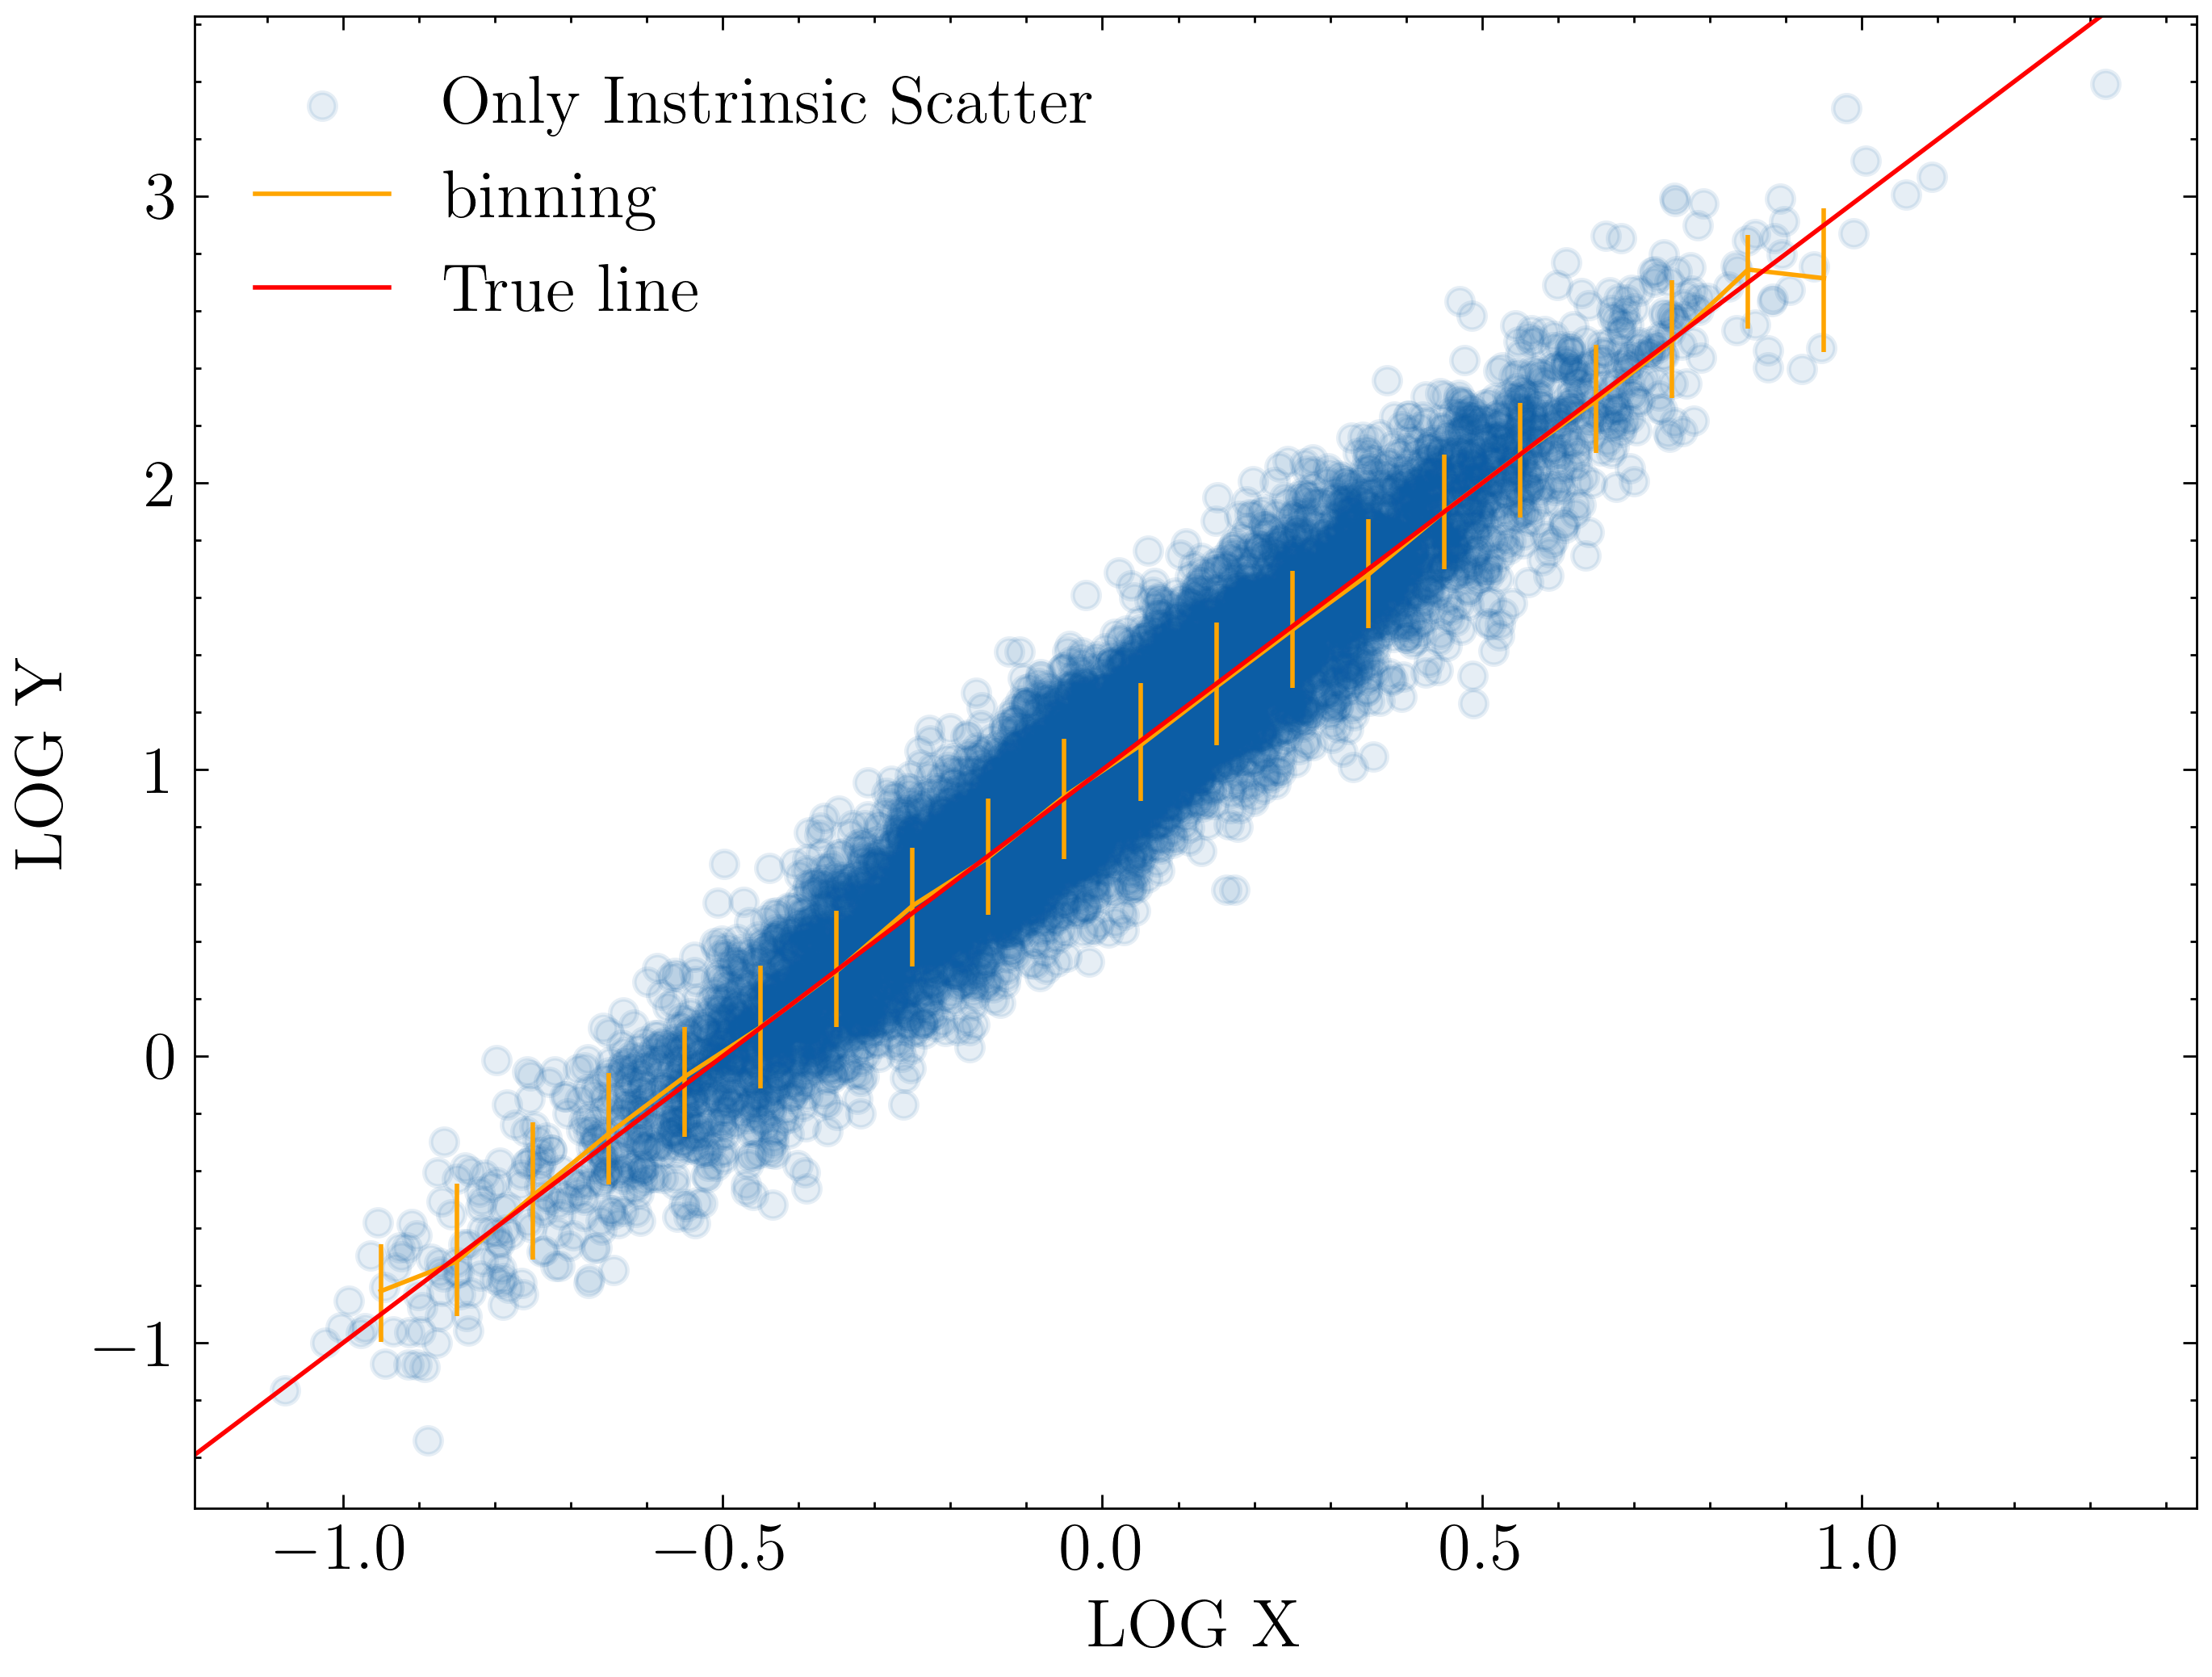

In [34]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(logx, logy, alpha=0.1, label='Only Instrinsic Scatter')
plot_trend(logx,
           logy,
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, b), slope=k, color='red', label='True line')

plt.xlabel('LOG X')
plt.ylabel('LOG Y')

plt.legend()

### Observational Errors

/tmp/ipykernel_2072511/3778333631.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(x_obs),
/tmp/ipykernel_2072511/3778333631.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs),
/tmp/ipykernel_2072511/3778333631.py:7: RuntimeWarning: invalid value encountered in log10
  plot_trend(np.log10(x_obs),
/tmp/ipykernel_2072511/3778333631.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs),


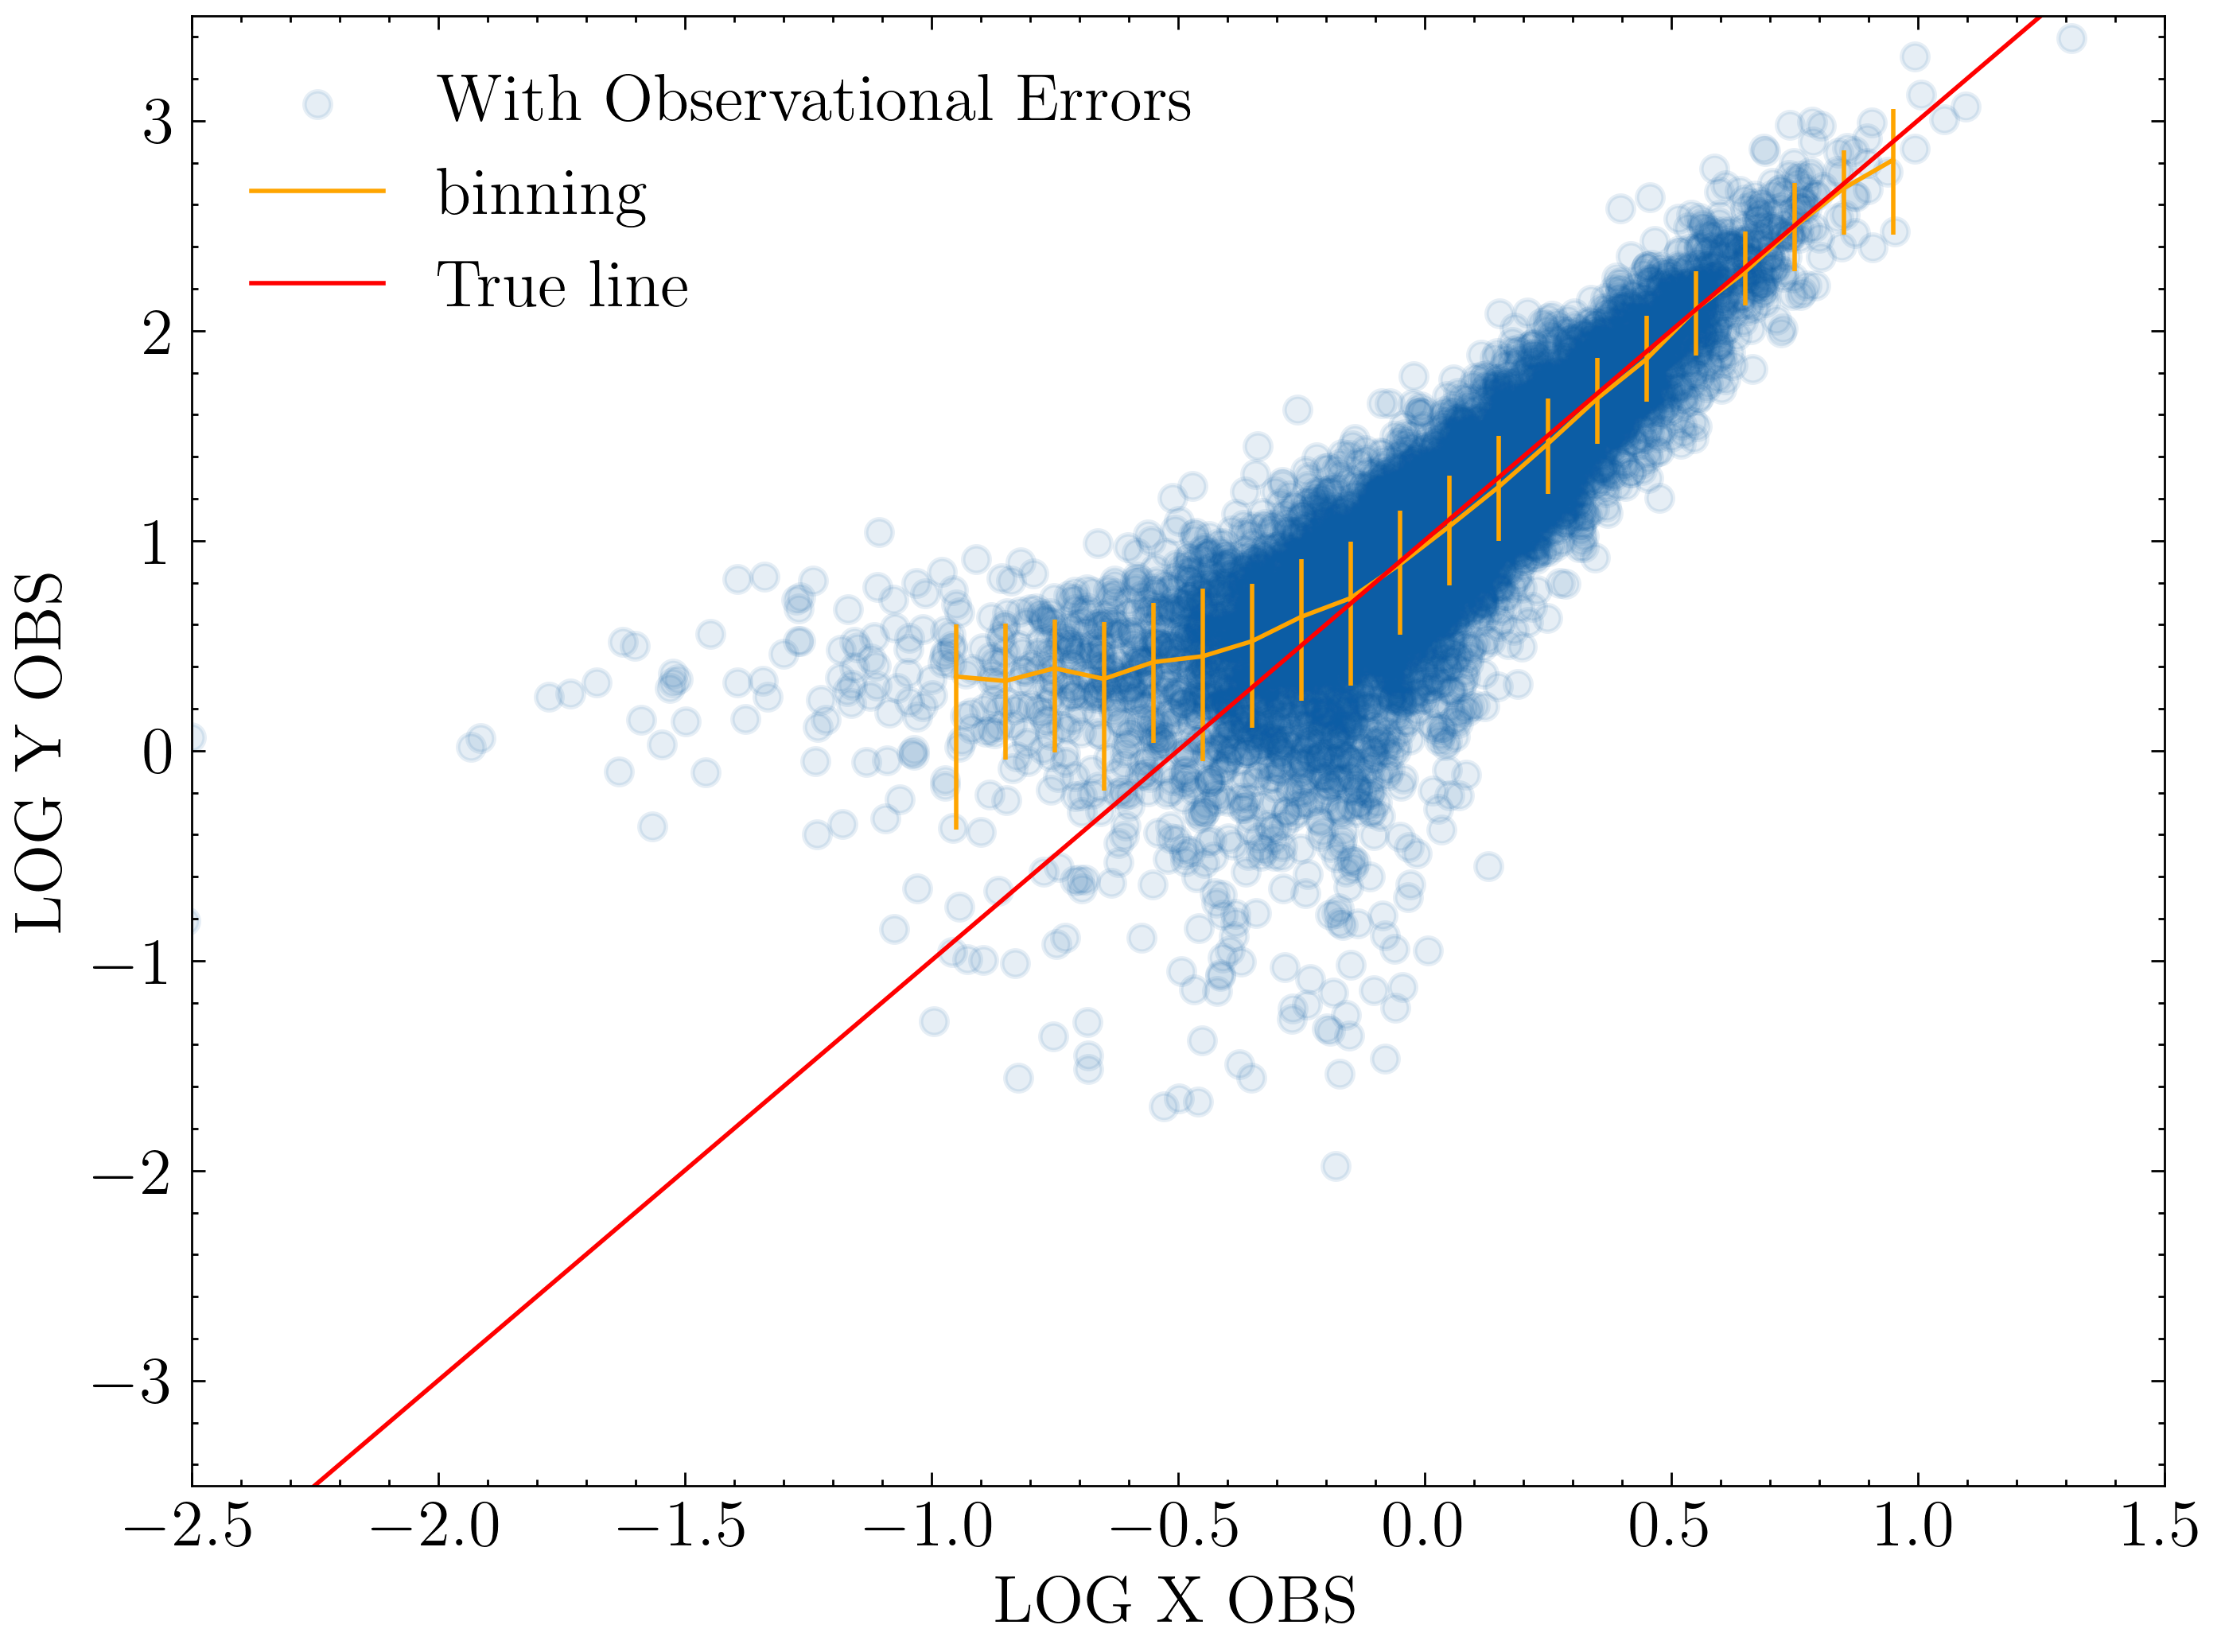

In [35]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(np.log10(x_obs),
            np.log10(y_obs),
            alpha=0.1,
            label='With Observational Errors')
plot_trend(np.log10(x_obs),
           np.log10(y_obs),
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, b), slope=k, color='red', label='True line')

plt.xlabel('LOG X OBS')
plt.ylabel('LOG Y OBS')

plt.xlim(-2.5, 1.5)
plt.ylim(-3.5, 3.5)

plt.legend()

In [37]:
xflow = FlowVI(x_min=0,
               x_max=x_obs.max(),
               x_err_min=0,
               x_err_max=x_err.max() * 1.2,
               transfer=NegLogPlus())

xflow.fit(x_obs, x_err, guess_method='auto', verbose=True)

100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


step 0: loss -2.01940655708313
step 10: loss -2.0849006175994873
step 20: loss -2.092904567718506
step 30: loss -2.0964407920837402
step 40: loss -2.097377300262451
step 50: loss -2.0980141162872314
step 60: loss -2.0986287593841553


In [38]:
xflow.ks_test(x_obs, x_err, 10000)

(0.013900003395974636, 0.5555059313655262)

In [39]:
yflow = FlowVI(x_min=0,
               x_max=y_obs.max(),
               x_err_min=0,
               x_err_max=y_err.max() * 1.2,
               transfer=NegLogPlus())

yflow.fit(y_obs, y_err, verbose=True)

100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


step 0: loss 3.336881637573242
step 10: loss 3.282562494277954
step 20: loss 3.2785420417785645
step 30: loss 3.276580810546875
step 40: loss 3.2749574184417725
step 50: loss 3.274259090423584
step 60: loss 3.2735438346862793


In [40]:
yflow.ks_test(y_obs, y_err, 10000)

(0.010650030337274075, 0.8540451533036397)

In [41]:
logLinear_ML = LogLinearML(xflow, yflow)

In [42]:
params_ml, params_std, cov = logLinear_ML.fit(
    x_obs,
    x_err,
    y_obs,
    y_err,
    [2., 1., 0.2],
    kde_batch_size=None,  # set it to 100000 or less if OOM
    verbose=True)  # loss is log-likelihood/n_samples

0 2.0000072 0.99975437 0.20001224 1.0769633
1000 2.0256014 0.9770515 0.2020123 1.0800658
2000 2.0378337 0.97523403 0.20168373 1.0802275
3000 2.0431473 0.9744369 0.20155756 1.0802581
4000 2.045455 0.9740898 0.20150584 1.0802639
converged, so stop with 4000 iterations


Array([2.045455  , 0.9740898 , 0.20150584], dtype=float32)

/tmp/ipykernel_2072511/3768825433.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(x_obs),
/tmp/ipykernel_2072511/3768825433.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs),
/tmp/ipykernel_2072511/3768825433.py:7: RuntimeWarning: invalid value encountered in log10
  plot_trend(np.log10(x_obs),
/tmp/ipykernel_2072511/3768825433.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs),


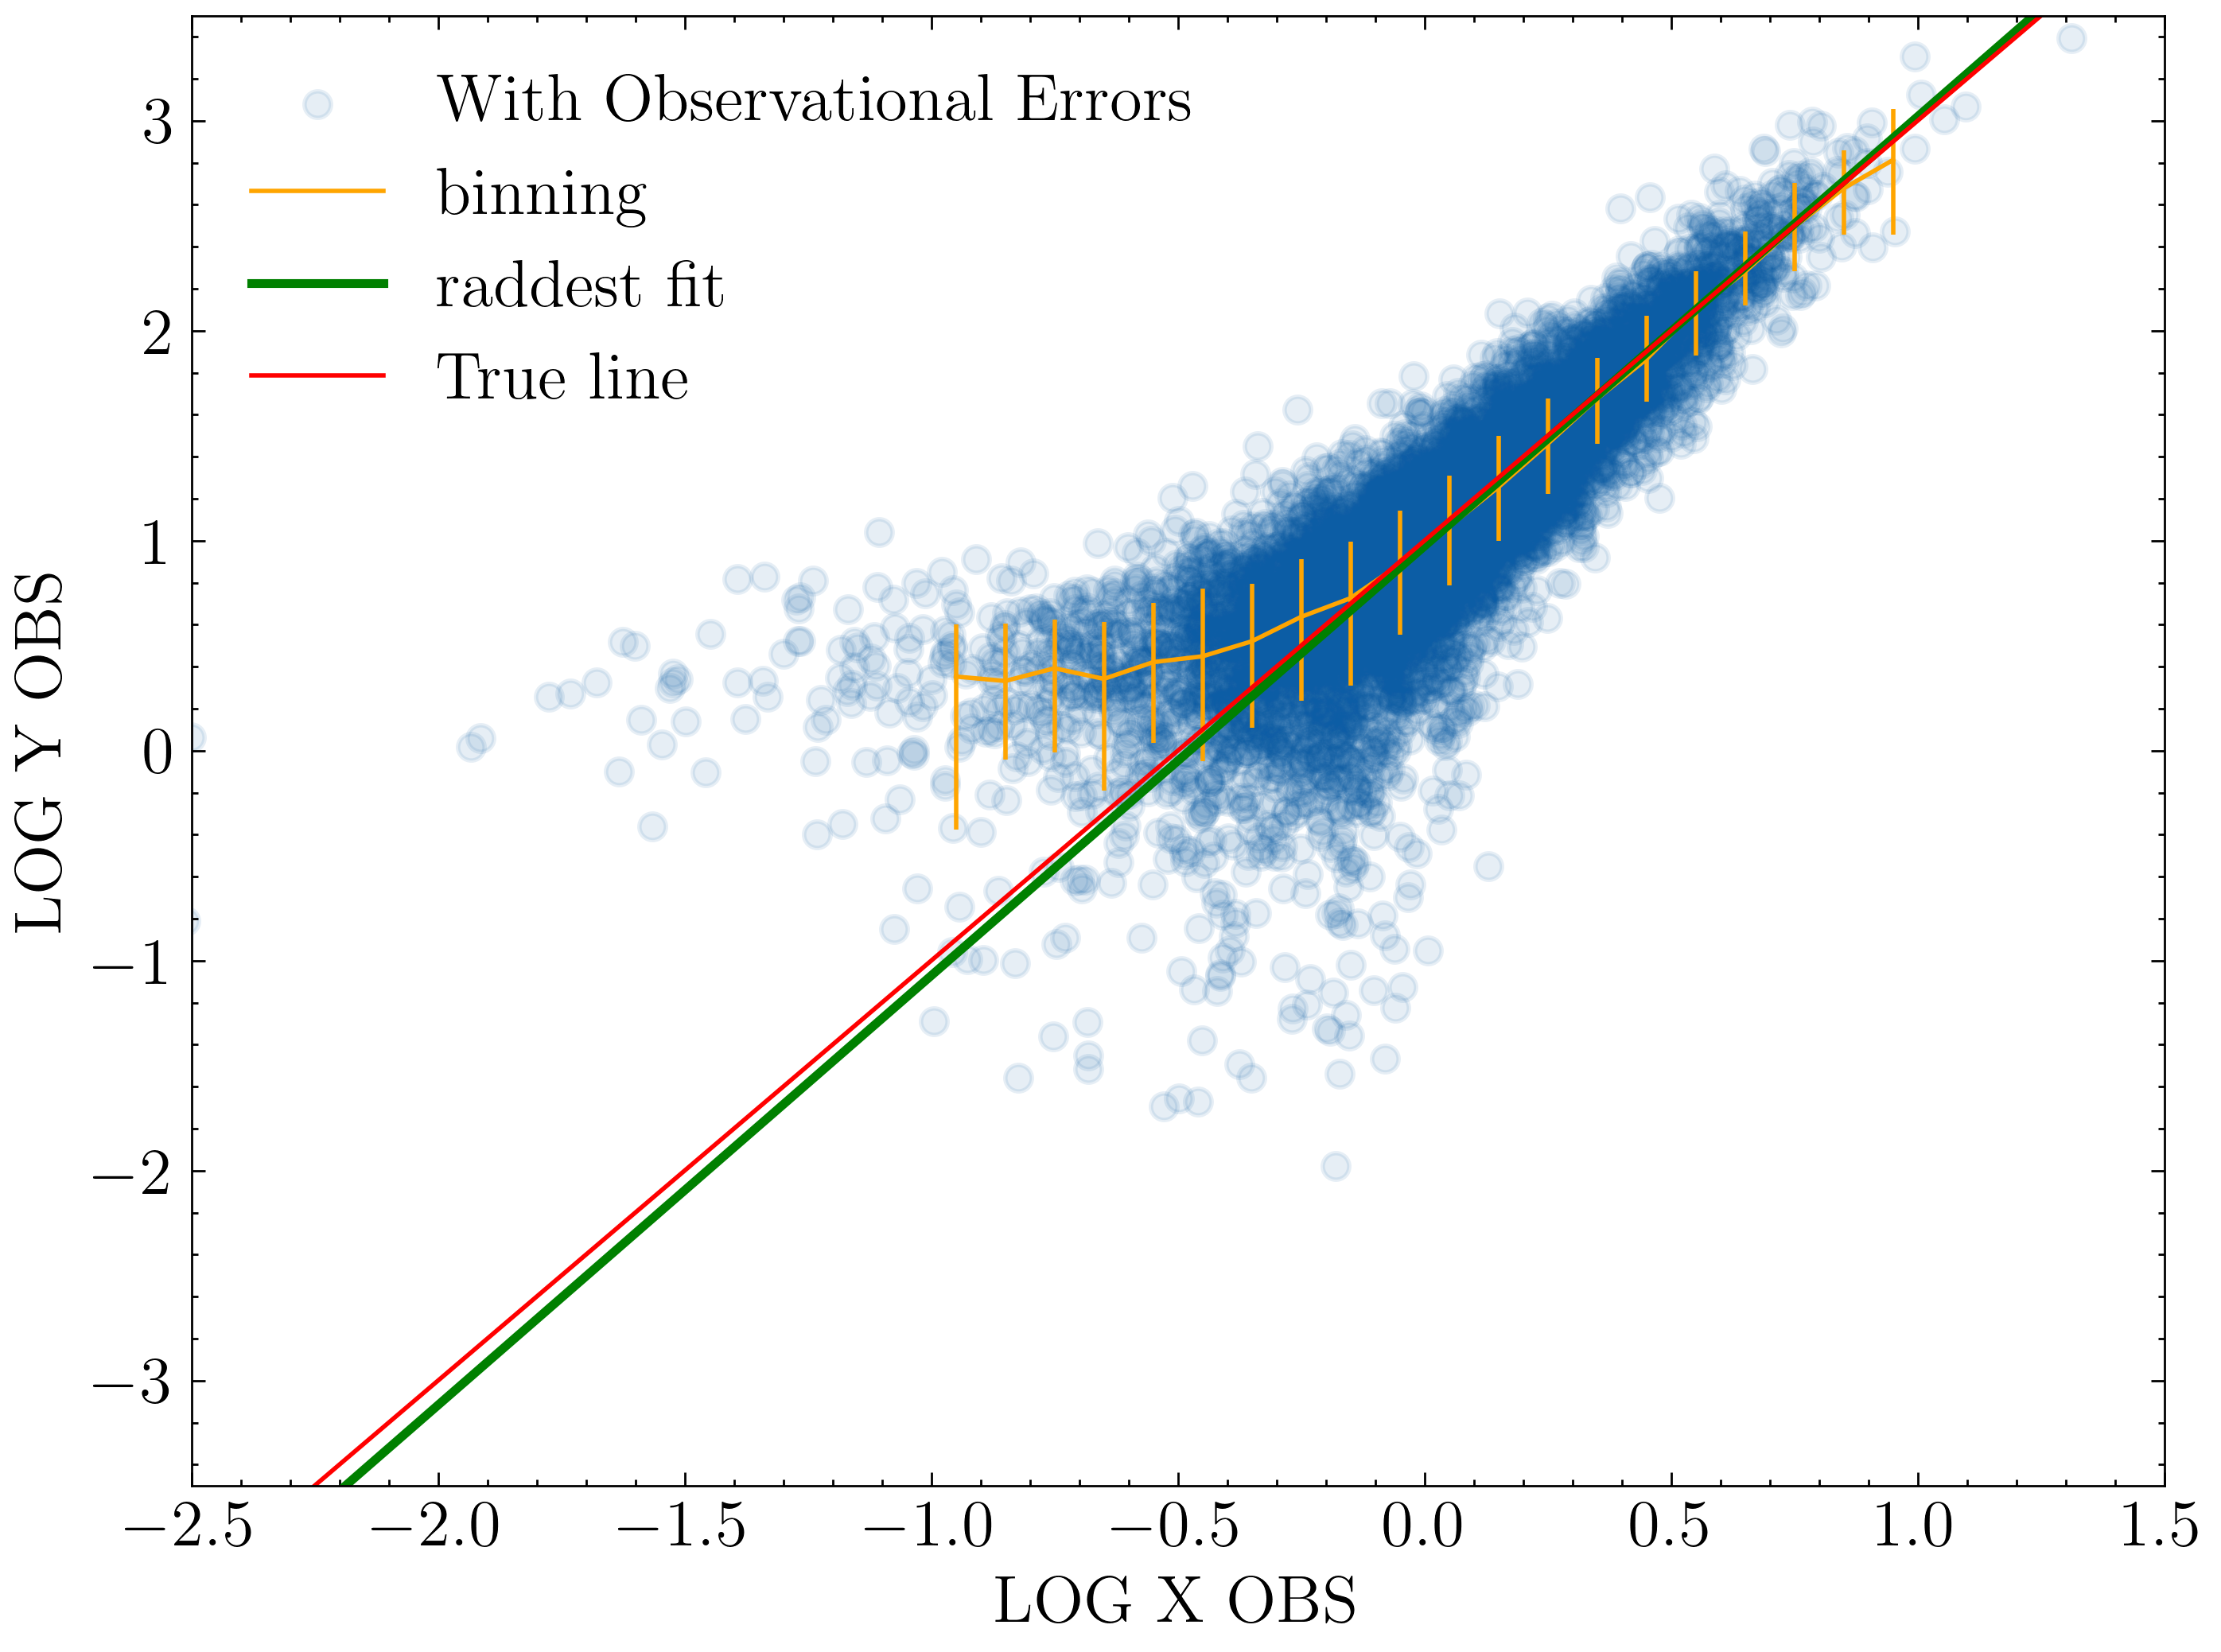

In [47]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(np.log10(x_obs),
            np.log10(y_obs),
            alpha=0.1,
            label='With Observational Errors')
plot_trend(np.log10(x_obs),
           np.log10(y_obs),
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, params_ml[1]), slope=params_ml[0], color='green', label='raddest fit', lw=2)
plt.axline((0, b), slope=k, color='red', label='True line')


plt.xlabel('LOG X OBS')
plt.ylabel('LOG Y OBS')

plt.xlim(-2.5, 1.5)
plt.ylim(-3.5, 3.5)

plt.legend()

### Larger Error

/tmp/ipykernel_2072511/1724597812.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(x_obs_2),
/tmp/ipykernel_2072511/1724597812.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs_2),
/tmp/ipykernel_2072511/1724597812.py:7: RuntimeWarning: invalid value encountered in log10
  plot_trend(np.log10(x_obs_2),
/tmp/ipykernel_2072511/1724597812.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs_2),


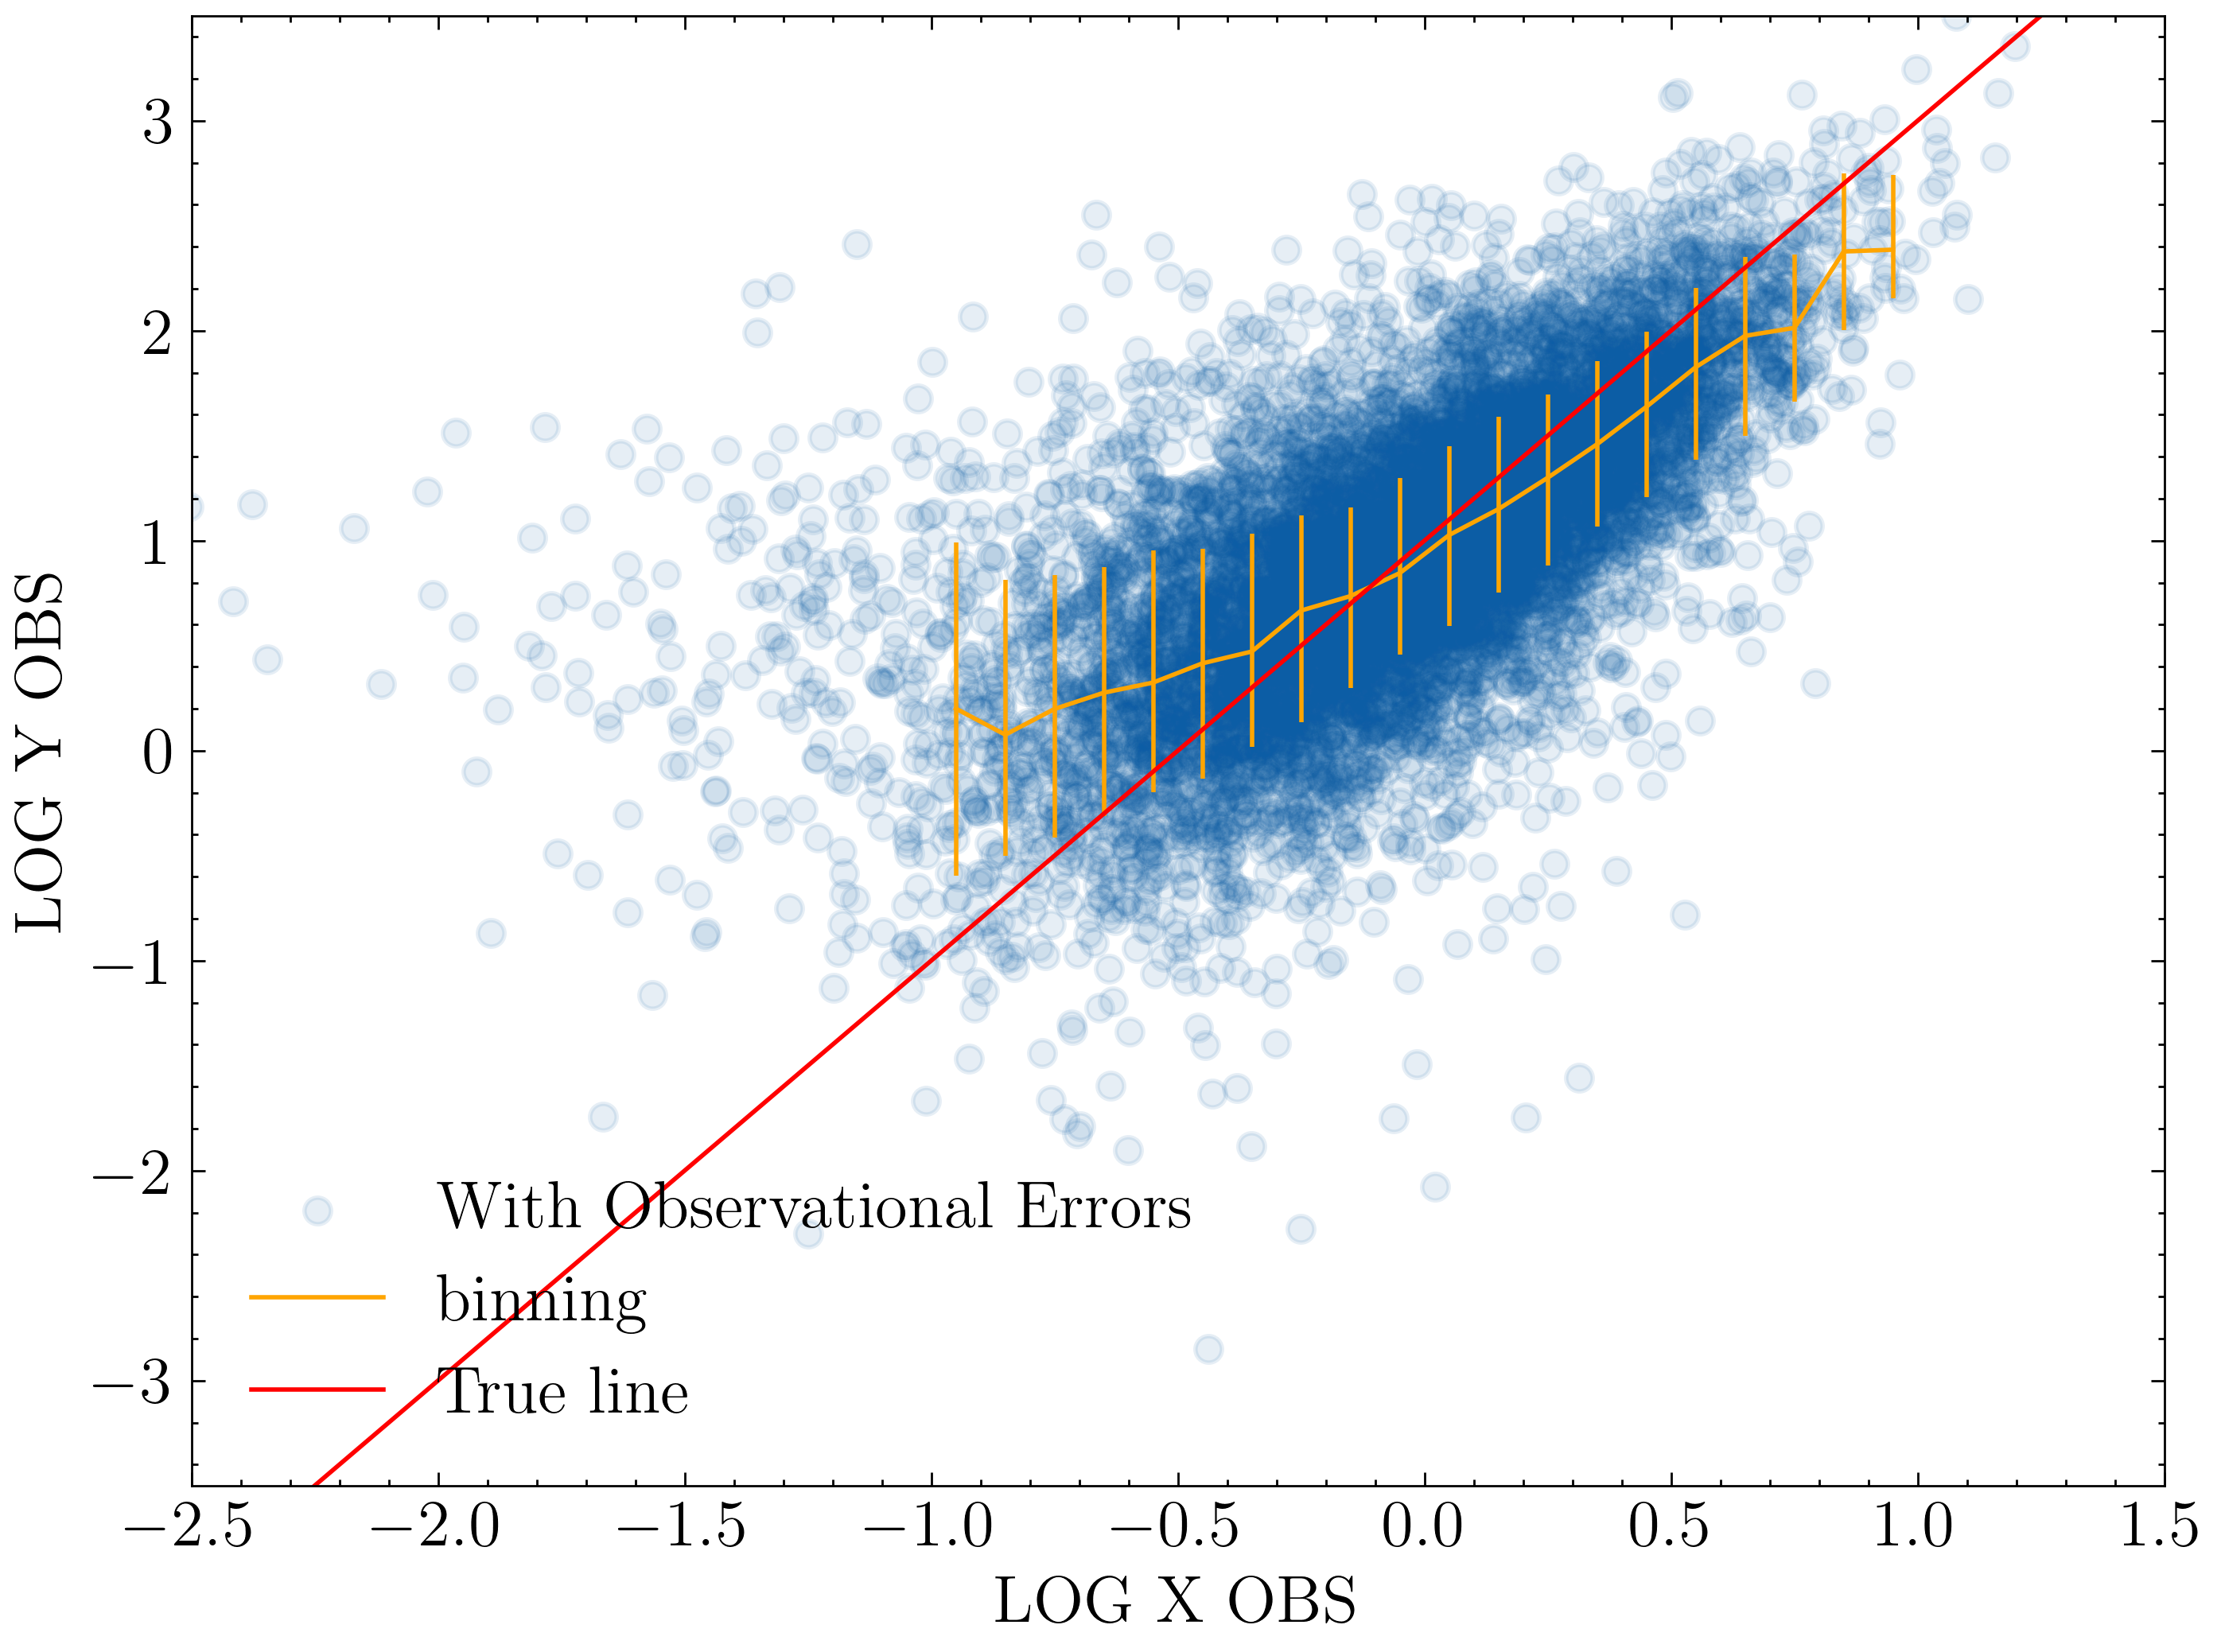

In [36]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(np.log10(x_obs_2),
            np.log10(y_obs_2),
            alpha=0.1,
            label='With Observational Errors')
plot_trend(np.log10(x_obs_2),
           np.log10(y_obs_2),
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, 1), slope=2, color='red', label='True line')

plt.xlabel('LOG X OBS')
plt.ylabel('LOG Y OBS')

plt.xlim(-2.5, 1.5)
plt.ylim(-3.5, 3.5)

plt.legend()

In [13]:
xflow = FlowVI(x_min=0,
               x_max=x_obs_2.max(),
               x_err_min=0,
               x_err_max=x_err_2.max() * 1.2,
               transfer=NegLogPlus())

xflow.fit(x_obs_2, x_err_2, guess_method='auto', verbose=True)

100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


step 0: loss 1.2265413999557495
step 10: loss 1.169843077659607
step 20: loss 1.1602526903152466
step 30: loss 1.1561335325241089
step 40: loss 1.153712272644043
step 50: loss 1.152305006980896
step 60: loss 1.1513091325759888


In [14]:
xflow.ks_test(x_obs_2, x_err_2, 10000)

(0.01345000322908163, 0.5124930250230333)

In [15]:
yflow = FlowVI(x_min=0,
               x_max=y_obs_2.max(),
               x_err_min=0,
               x_err_max=y_err_2.max() * 1.2,
               transfer=NegLogPlus())

yflow.fit(y_obs_2, y_err_2, guess_method='auto', verbose=True)

100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


step 0: loss 7.70838737487793
step 10: loss 6.701010704040527
step 20: loss 6.609549045562744
step 30: loss 6.54065465927124
step 40: loss 6.51039457321167
step 50: loss 6.496181964874268
step 60: loss 6.488714218139648
step 70: loss 6.484470367431641


In [16]:
yflow.ks_test(y_obs_2, y_err_2, 10000)

(0.018799982964992523, 0.12878370426086136)

In [17]:
logLinear_ML = LogLinearML(xflow, yflow)

In [18]:
params_ml, params_std, cov = logLinear_ML.fit(
    x_obs_2,
    x_err_2,
    y_obs_2,
    y_err_2,
    [2., 1., 0.2],
    kde_batch_size=None,  # set it to 100000 or less if OOM
    verbose=True)  # loss is log-likelihood/n_samples

0 1.9999807 0.99974525 0.19972904 -5.2557454
1000 1.996697 0.9823315 0.18258747 -5.251056
2000 1.9960597 0.98234075 0.18261543 -5.2510552
converged, so stop with 2000 iterations


/tmp/ipykernel_2077732/918236616.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(x_obs_2),
/tmp/ipykernel_2077732/918236616.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs_2),
/tmp/ipykernel_2077732/918236616.py:7: RuntimeWarning: invalid value encountered in log10
  plot_trend(np.log10(x_obs_2),
/tmp/ipykernel_2077732/918236616.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(y_obs_2),


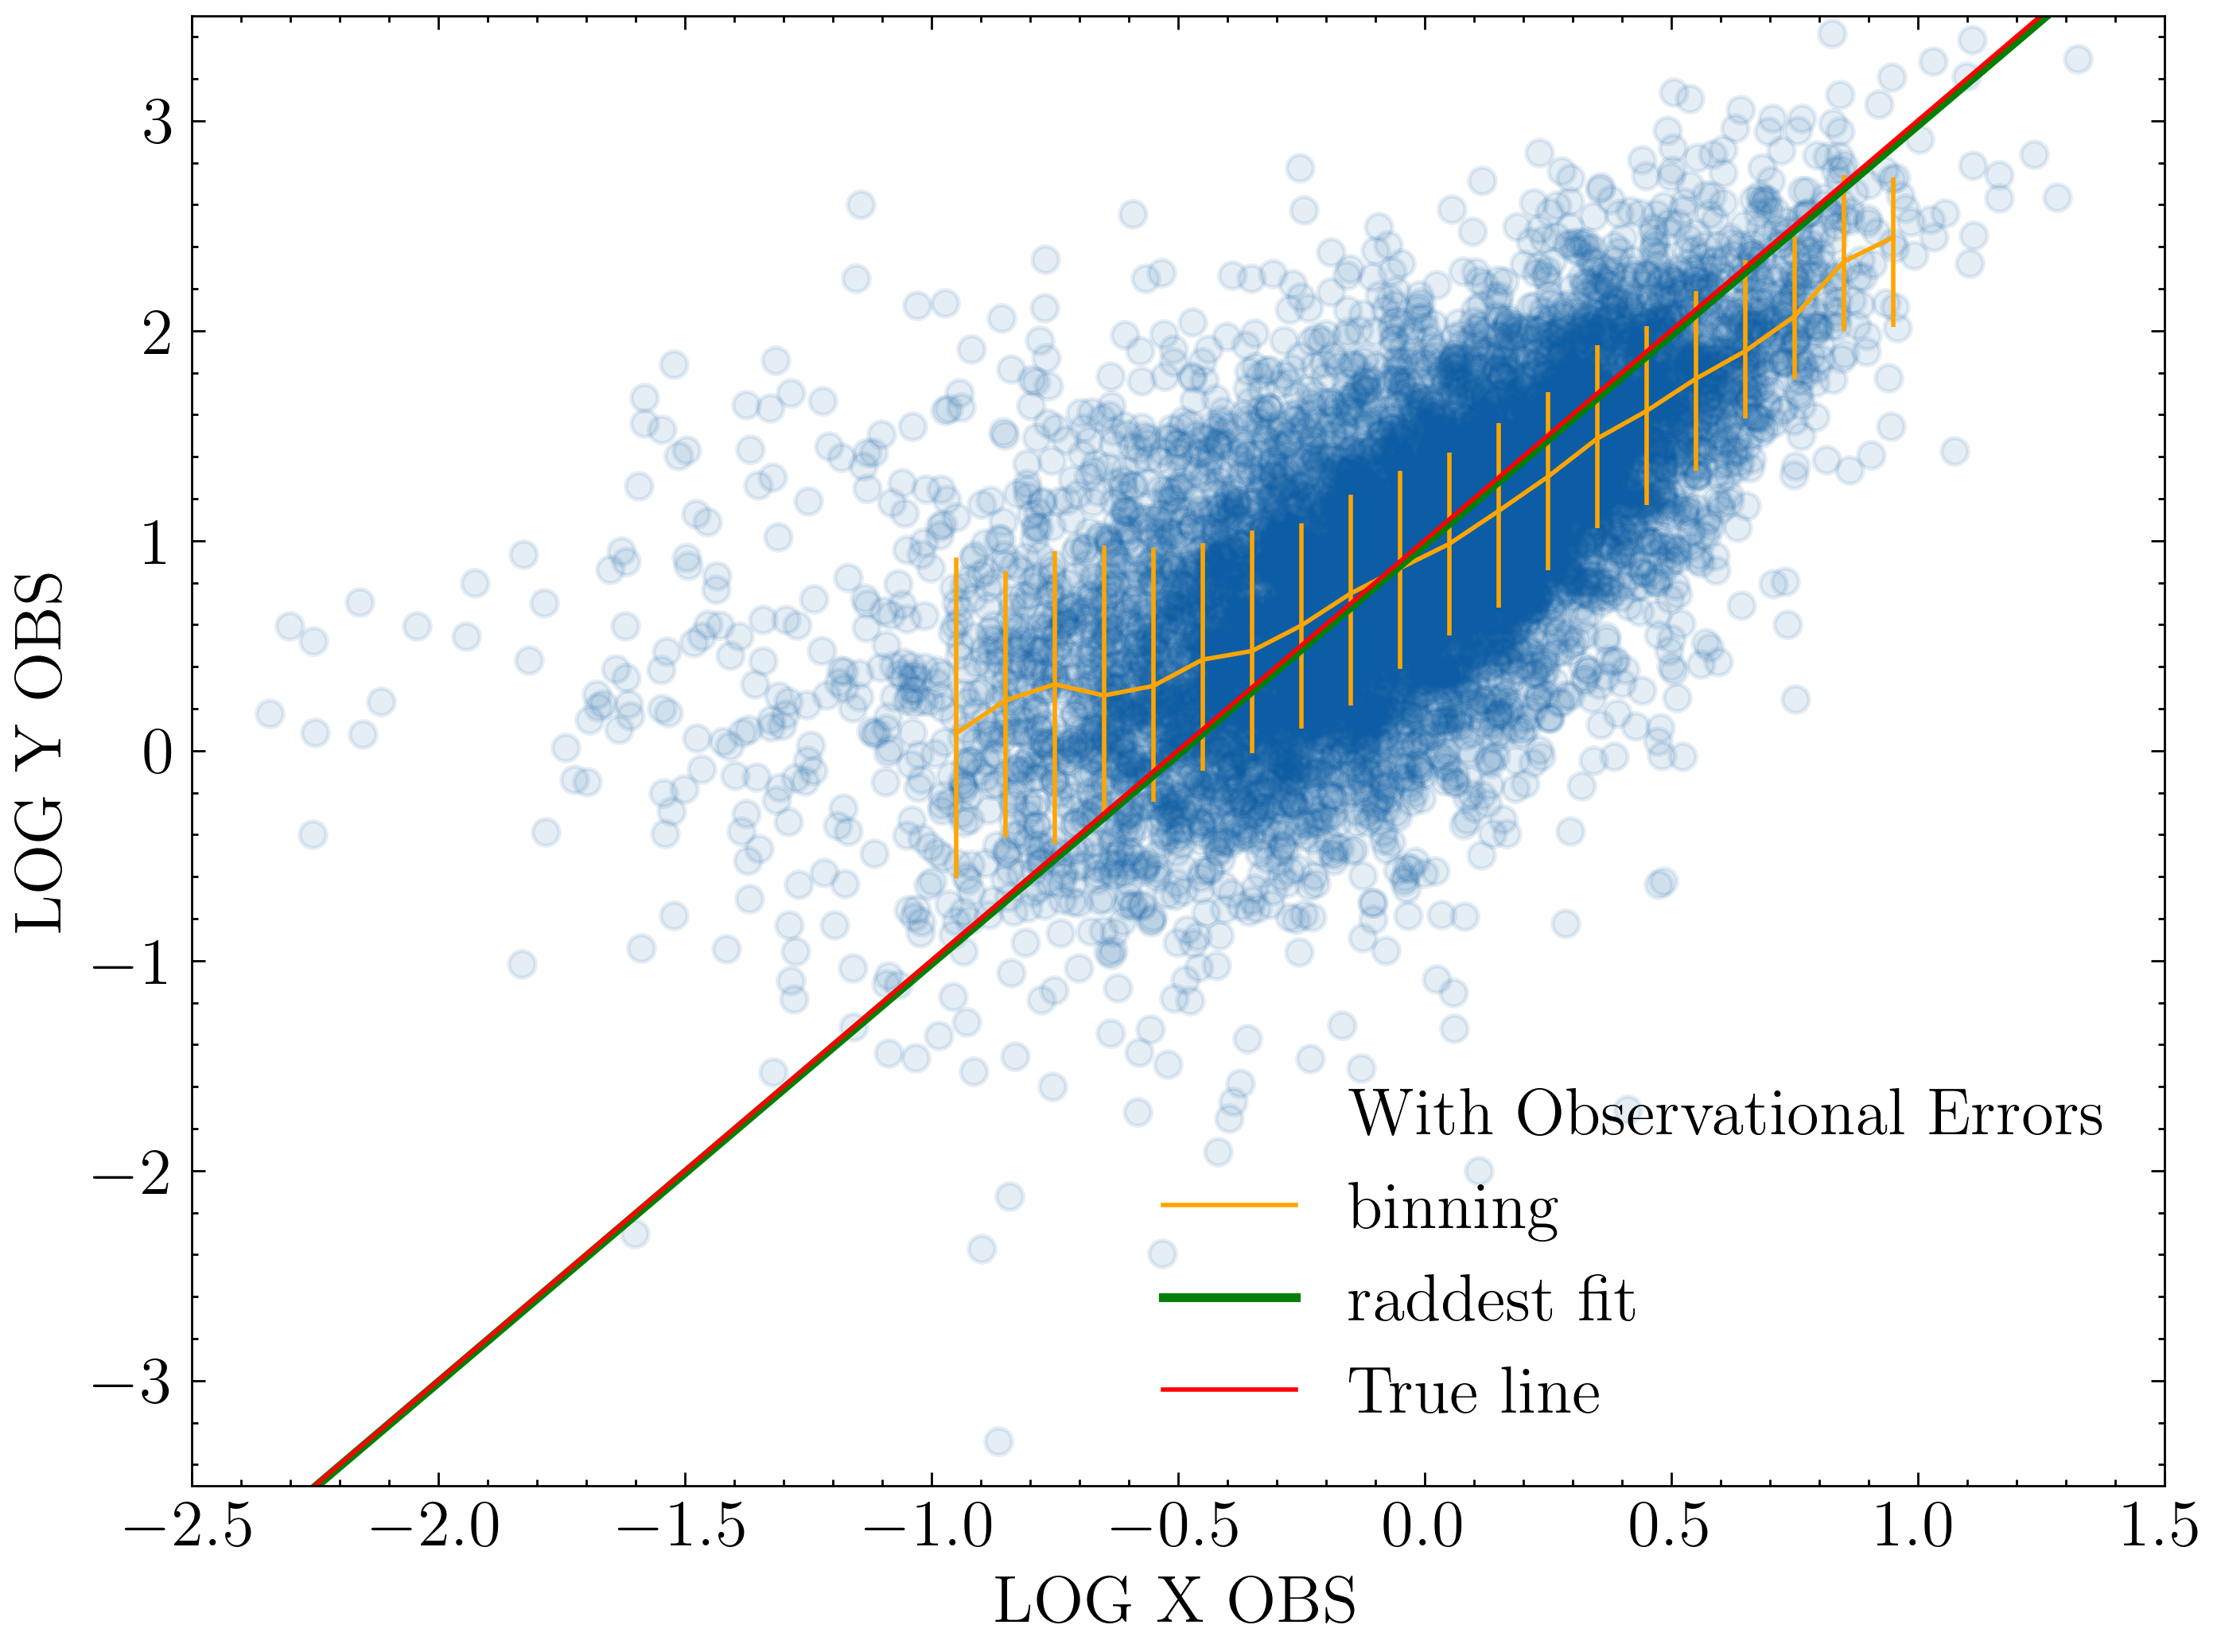

In [19]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(np.log10(x_obs_2),
            np.log10(y_obs_2),
            alpha=0.1,
            label='With Observational Errors')
plot_trend(np.log10(x_obs_2),
           np.log10(y_obs_2),
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, params_ml[1]), slope=params_ml[0], color='green', label='raddest fit', lw=2)
plt.axline((0, b), slope=k, color='red', label='True line')

plt.xlabel('LOG X OBS')
plt.ylabel('LOG Y OBS')

plt.xlim(-2.5, 1.5)
plt.ylim(-3.5, 3.5)

plt.legend()

### Incompleteness

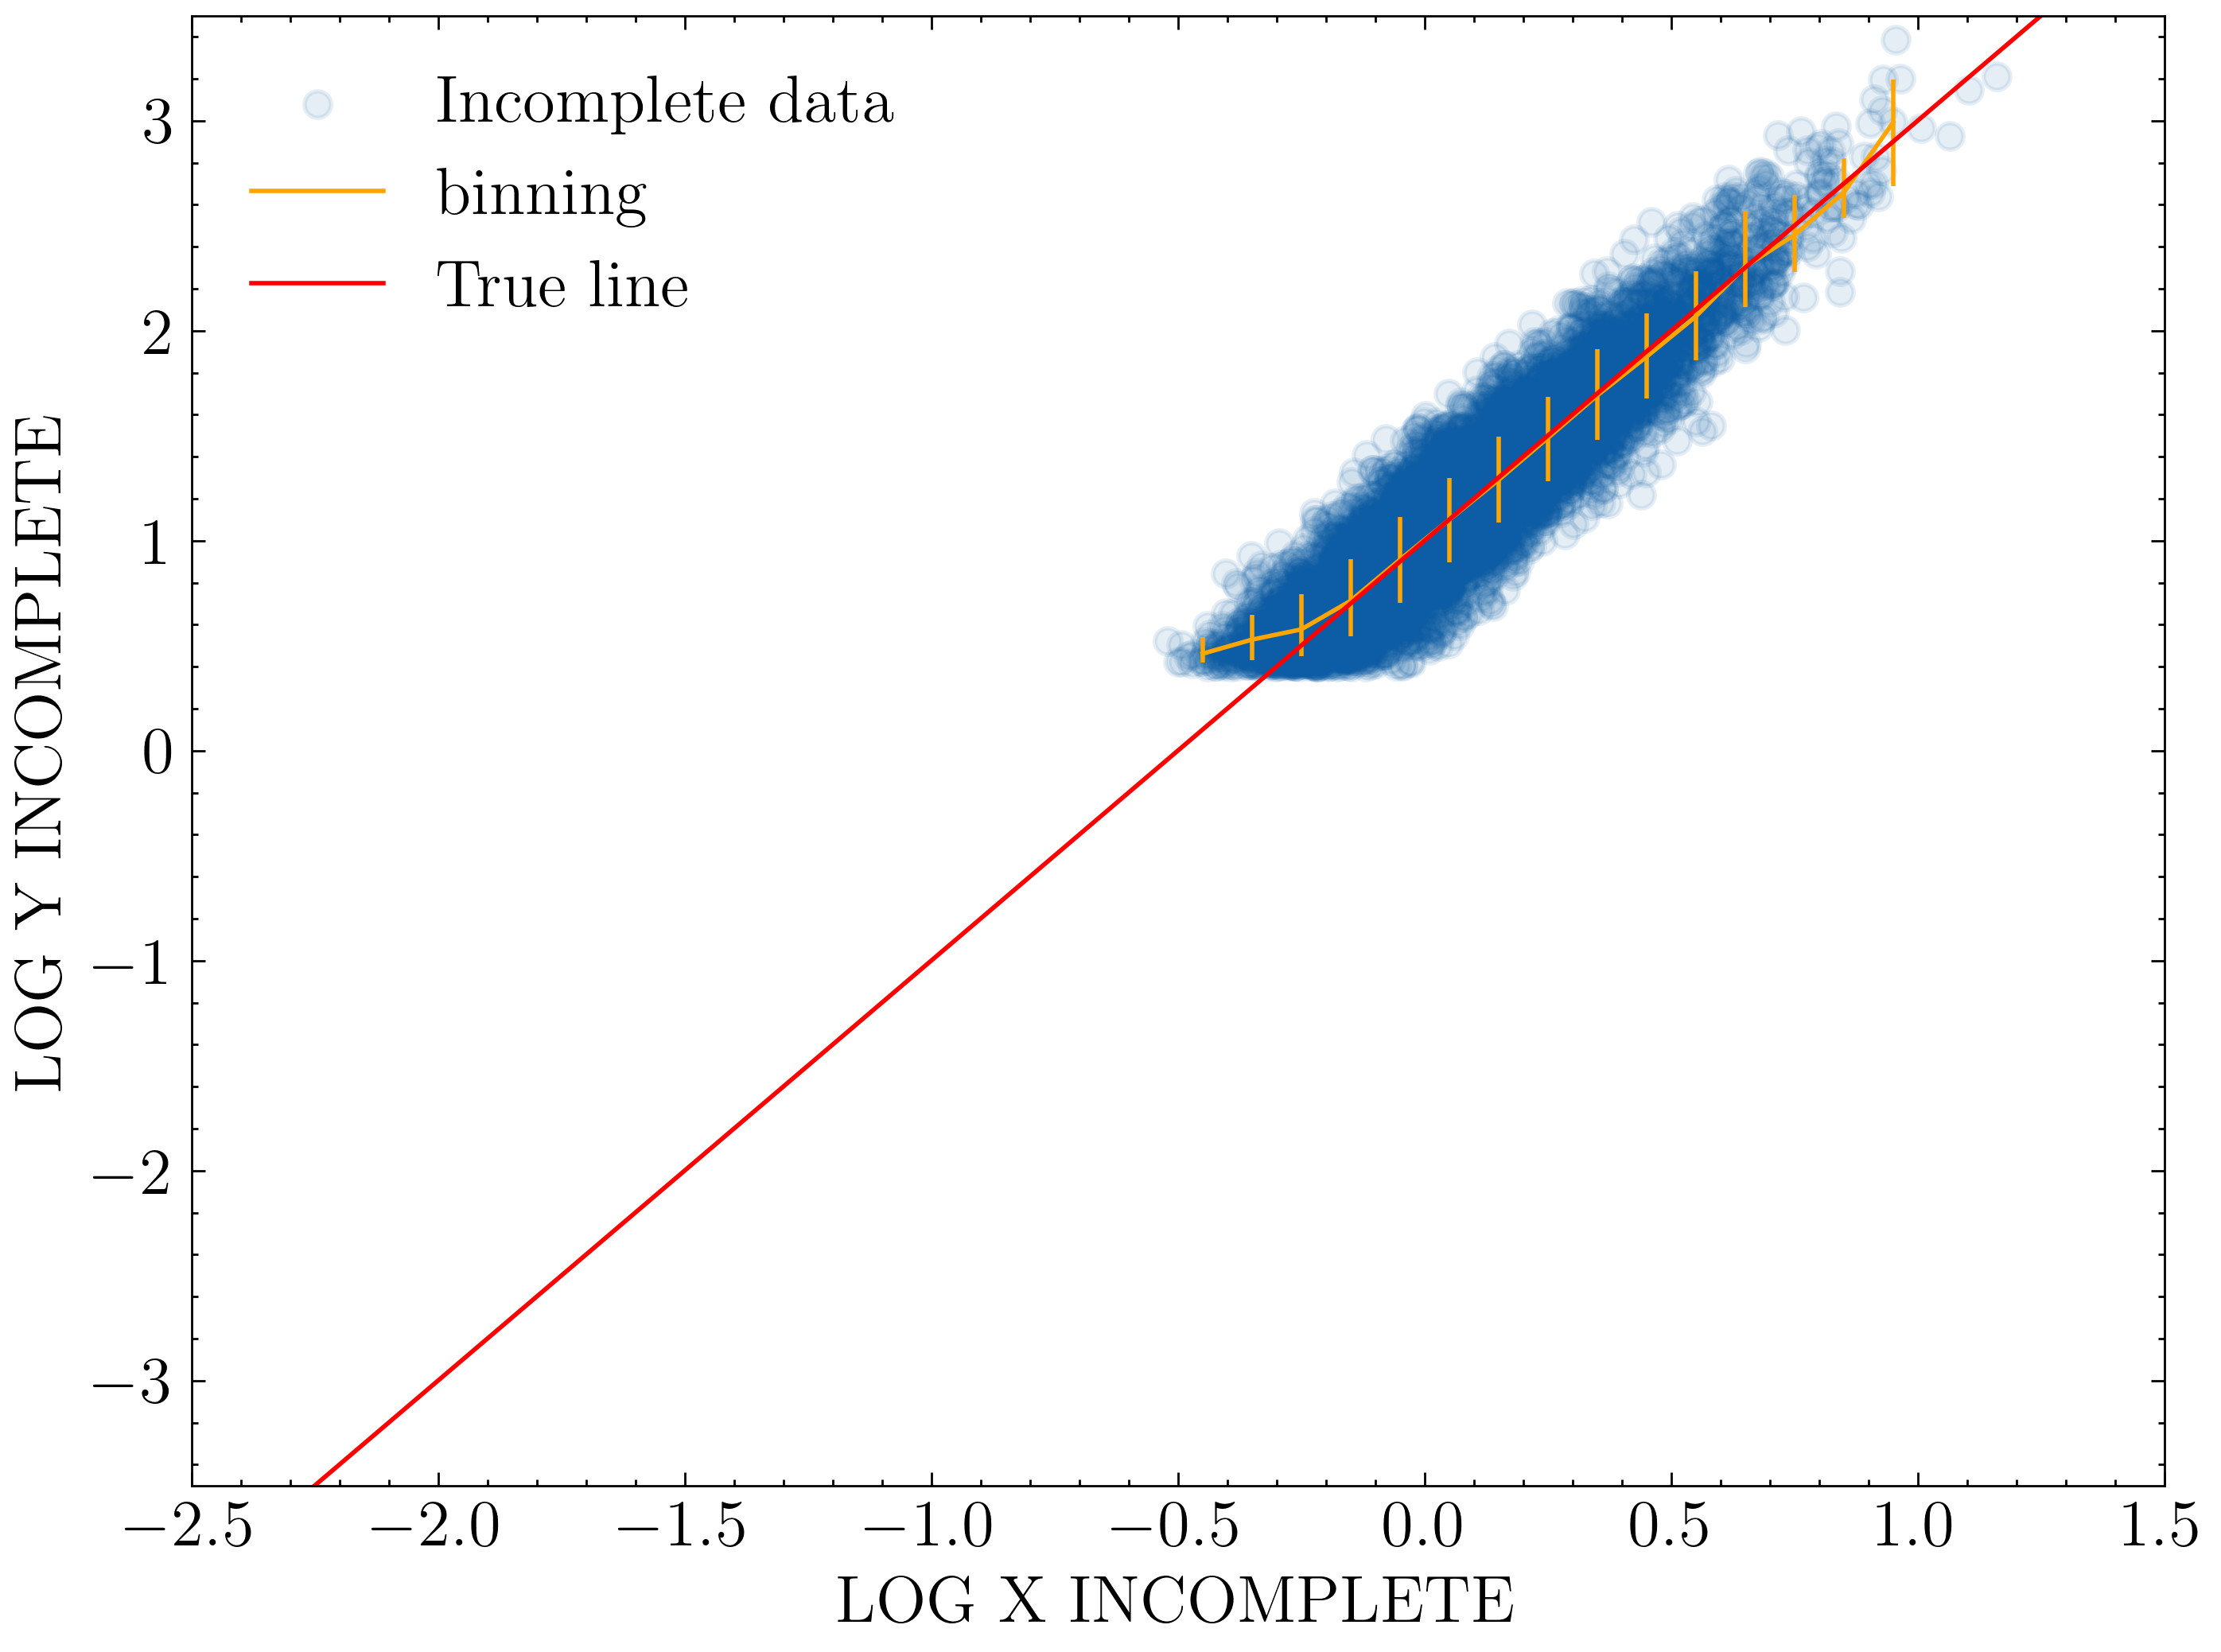

In [104]:
plt.figure(figsize=(8, 6), dpi=400)

can_be_obs = y > 10**0.4

plt.scatter(np.log10(x[can_be_obs]),
            np.log10(y[can_be_obs]),
            alpha=0.1,
            label='Incomplete data')
plot_trend(np.log10(x[can_be_obs]),
           np.log10(y[can_be_obs]),
           color='orange',
           plot_kwargs={'label': 'binning'},
           range=[-1, 1])
plt.axline((0, 1), slope=2, color='red', label='True line')

plt.xlabel('LOG X INCOMPLETE')
plt.ylabel('LOG Y INCOMPLETE')

plt.xlim(-2.5, 1.5)
plt.ylim(-3.5, 3.5)
plt.legend()